### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Load Dataset

In [2]:
# Load dataset
df = pd.read_csv('../00_dataset/YelpZip/metadata', 
                 sep='\t',
                 header=None,
                 names=["user_id", "prod_id", "rating", "label", "date"])


positive_df = df[(df['label'] == 1)]
negative_df = df[(df['label'] == -1)]
negative_df["label"] = 0
dataset_df = pd.concat([positive_df, negative_df])
dataset_df

C:\Users\imman\AppData\Local\Temp\ipykernel_28460\115790267.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df["label"] = 0


,user_id,prod_id,rating,label,date
7,5051,0,1.0,1,2014-12-05
8,5052,0,2.0,1,2014-11-26
9,5053,0,4.0,1,2014-11-17
10,5054,0,3.0,1,2014-10-20
11,5055,0,5.0,1,2014-10-13
...,...,...,...,...,...
608583,265316,5042,5.0,0,2014-12-24
608586,247830,5039,3.0,0,2011-12-03
608587,265318,5039,4.0,0,2015-01-02
608588,100625,5039,4.0,0,2013-11-02


### Split Dataset

In [3]:
# Splitting the dataset
y = dataset_df['label']
X = dataset_df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## No Feature Engineering

In [4]:
noFE_train, noFE_test = X_train.copy(), X_test.copy()
noFE_train['date'] = pd.to_datetime(noFE_train['date']).astype('int64') // 10**9
noFE_test['date'] = pd.to_datetime(noFE_test['date']).astype('int64') // 10**9

noFE_train = noFE_train.drop(columns=["user_id", "prod_id"])
noFE_test = noFE_test.drop(columns=["user_id", "prod_id"])

In [5]:
print(noFE_train.dtypes)
print(y_train.value_counts())

rating    float64
date        int64
dtype: object
label
1    369625
0     56393
Name: count, dtype: int64


### Evaluate No Feature Engineering

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Initialize classifier
gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

# Train classifier using all features
gbc.fit(noFE_train, y_train)

# Make predictions
preds = gbc.predict(noFE_test)

# Evaluate the model using the F1-score
f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)

print(f1_score_all)

0.807


### Apply Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_noFE_train = pd.DataFrame(scaler.fit_transform(noFE_train), columns=noFE_train.columns)
scaled_noFE_test = pd.DataFrame(scaler.transform(noFE_test), columns=noFE_test.columns)


### Plot Features

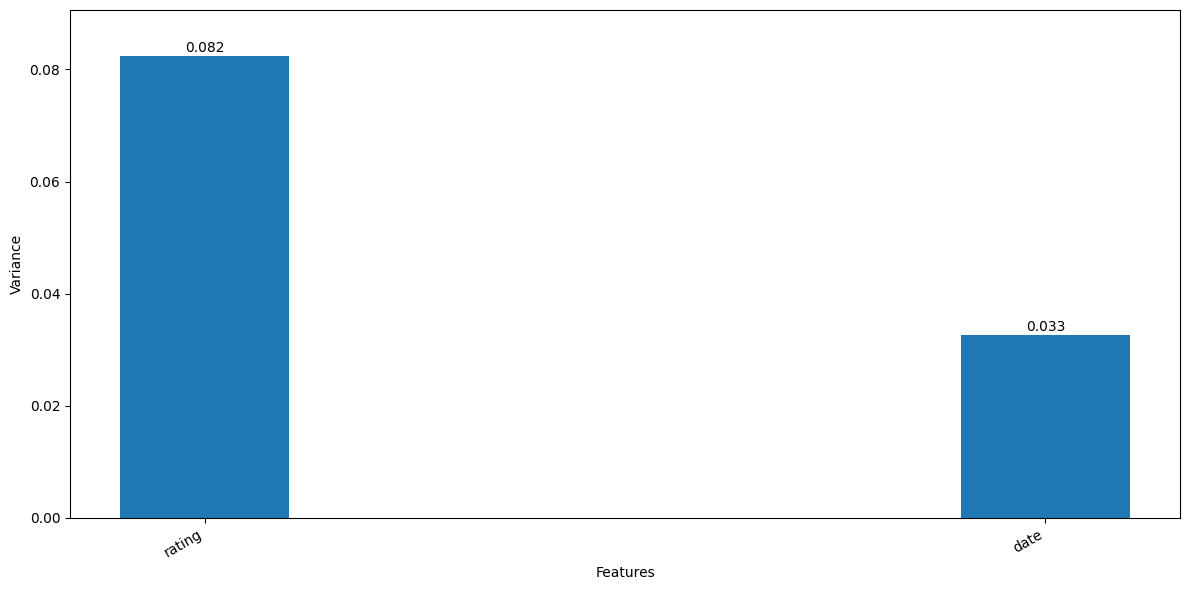

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

x = scaled_noFE_train.columns
y = scaled_noFE_train.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, max(y) * 1.1)

for index, value in enumerate(y):
    plt.text(index, value + (max(y) * 0.01), str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Feature Engineering

### Import and Apply Features

In [9]:
from FeatureEngineer import CombinedEngineer

# Instantiate and apply CombinedEngineer
feature_engineer = CombinedEngineer(drop_columns=[])  # Adjust drop_columns if needed
FE_train = feature_engineer.fit_transform(X_train)

# Apply to test data as well
FE_test = feature_engineer.transform(X_test)

# Check results
print(FE_train.info())  # Verify that NaNs are handled
print(FE_train.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426018 entries, 0 to 426017
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   rating                           426018 non-null  float64
 1   date                             426018 non-null  int64  
 2   total_reviews_for_restaurant     426018 non-null  int64  
 3   avg_rating_for_restaurant        426018 non-null  float64
 4   std_dev_rating_for_restaurant    426018 non-null  float64
 5   median_rating_for_restaurant     426018 non-null  float64
 6   review_frequency_for_restaurant  426018 non-null  float64
 7   extreme_rating_index             426018 non-null  float64
 8   user_restaurants_reviewed        426018 non-null  int64  
 9   rating_mean                      426018 non-null  float64
 10  rating_min                       426018 non-null  float64
 11  rating_max                       426018 non-null  float64
 12  ra

### Apply Scaler

In [ ]:
scaler = MinMaxScaler()
scaled_X_train_all = scaler.fit_transform(FE_train)

### Apply Feature Selection to Feature Engineered Data ###

In [11]:
# Mutual Information
mi_selector_FE = SelectKBest(mutual_info_classif, k=10)
X_train_mi_FE = mi_selector_FE.fit_transform(FE_train, y_train)
X_test_mi_FE = mi_selector_FE.transform(FE_test)

In [12]:
# Recursive Feature Elimination (RFE)
rfe_model_FE = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_selector_FE = RFE(rfe_model_FE, n_features_to_select=10)
X_train_rfe_FE = rfe_selector_FE.fit_transform(FE_train, y_train)
X_test_rfe_FE = rfe_selector_FE.transform(FE_test)

In [13]:
# Retrain model on selected features to prevent bias
rfe_final_model_FE = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_final_model_FE.fit(X_train_rfe_FE, y_train)

RandomForestClassifier(random_state=42)

In [14]:
print("Original Feature Count:", FE_train.shape[1])
print("Features after Mutual Info:", X_train_mi_FE.shape[1])
print("Features after RFE:", X_train_rfe_FE.shape[1])


Original Feature Count: 19
Features after Mutual Info: 10
Features after RFE: 10


In [15]:
print("Original Features:", FE_train.columns)
print("Features Selected by Mutual Info:", np.array(FE_train.columns)[mi_selector_FE.get_support()])
print("Features Selected by RFE:", np.array(FE_train.columns)[rfe_selector_FE.get_support()])

Original Features: Index(['rating', 'date', 'total_reviews_for_restaurant',
       'avg_rating_for_restaurant', 'std_dev_rating_for_restaurant',
       'median_rating_for_restaurant', 'review_frequency_for_restaurant',
       'extreme_rating_index', 'user_restaurants_reviewed', 'rating_mean',
       'rating_min', 'rating_max', 'rating_std', 'user_earliest',
       'user_latest', 'user_days_active', 'user_review_timespan',
       'users_avg_per_day', 'user_active_percentage'],
      dtype='object')
Features Selected by Mutual Info: ['rating' 'median_rating_for_restaurant' 'user_restaurants_reviewed'
 'rating_mean' 'rating_max' 'rating_std' 'user_days_active'
 'user_review_timespan' 'users_avg_per_day' 'user_active_percentage']
Features Selected by RFE: ['date' 'total_reviews_for_restaurant' 'avg_rating_for_restaurant'
 'std_dev_rating_for_restaurant' 'review_frequency_for_restaurant'
 'rating_mean' 'user_earliest' 'user_latest' 'user_review_timespan'
 'users_avg_per_day']


In [16]:
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

Train class distribution:
 label
1    0.867628
0    0.132372
Name: proportion, dtype: float64
Test class distribution:
 label
1    0.868151
0    0.131849
Name: proportion, dtype: float64


In [17]:
# Train separate models for different feature selection methods
baseline_model_FE = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_model_FE.fit(FE_train, y_train)

mi_model_FE = RandomForestClassifier(n_estimators=100, random_state=42)
mi_model_FE.fit(X_train_mi_FE, y_train)

RandomForestClassifier(random_state=42)

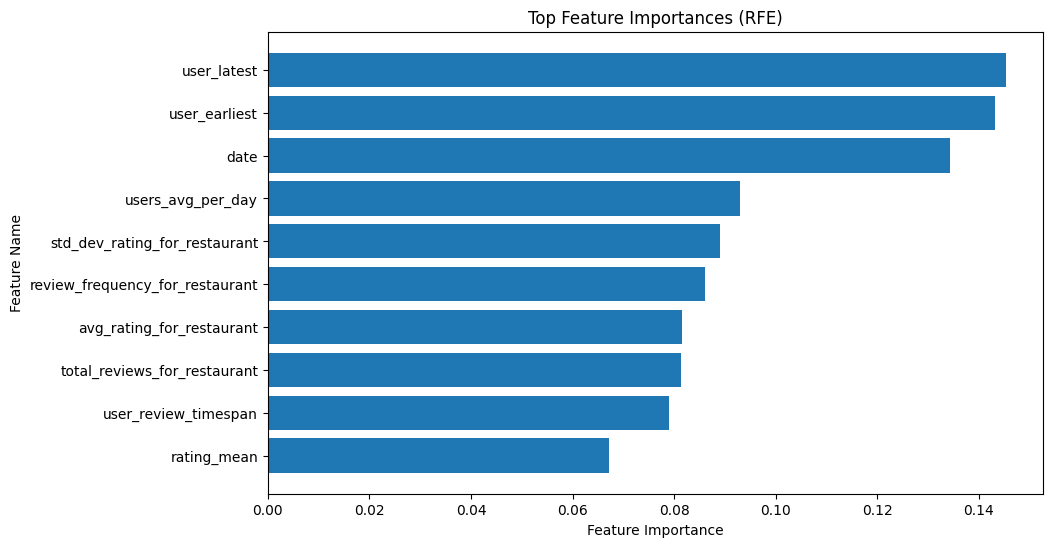

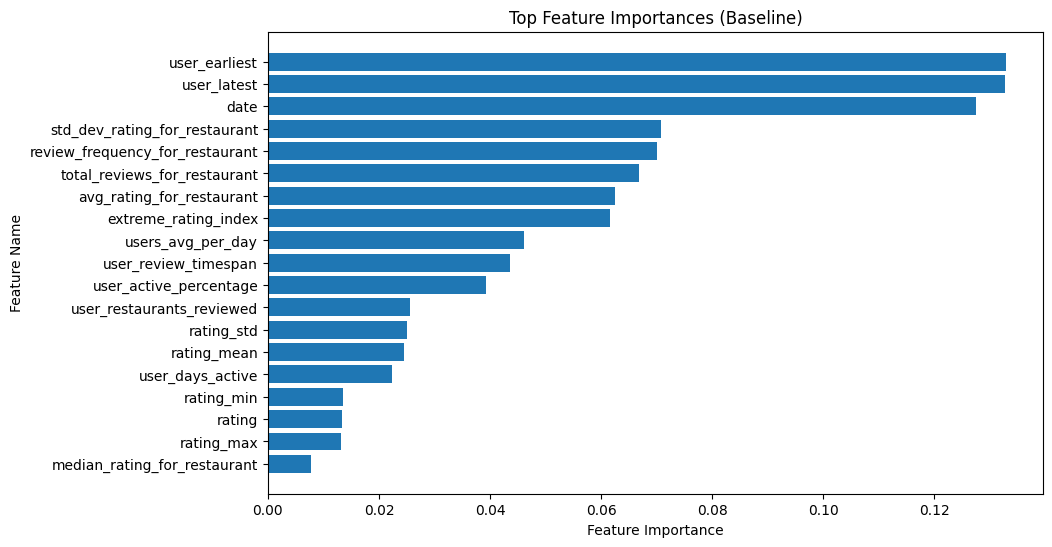

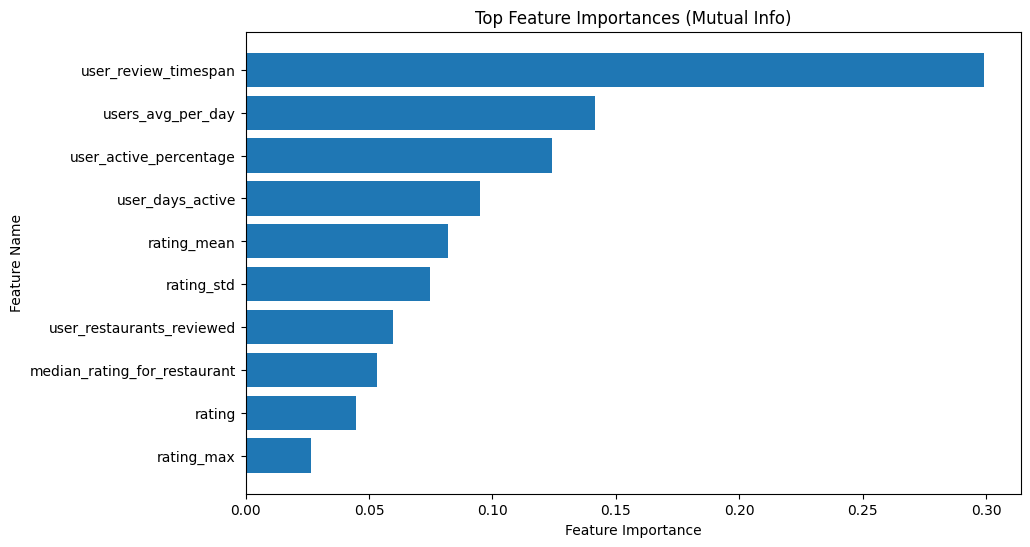

In [19]:
### Display Feature Importance for All Methods ###
def plot_feature_importance(model, feature_names, title):
    feature_importance = model.feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    
# Plot feature importance for all methods
plot_feature_importance(rfe_final_model_FE, np.array(FE_train.columns)[rfe_selector_FE.get_support()], 'Top Feature Importances (RFE)')
plot_feature_importance(baseline_model_FE, FE_train.columns, 'Top Feature Importances (Baseline)')
plot_feature_importance(mi_model_FE, np.array(FE_train.columns)[mi_selector_FE.get_support()], 'Top Feature Importances (Mutual Info)')

In [ ]:
print(FE_train.dtypes)


rating                             float64
date                                 int64
total_reviews_for_restaurant         int64
avg_rating_for_restaurant          float64
std_dev_rating_for_restaurant      float64
median_rating_for_restaurant       float64
review_frequency_for_restaurant    float64
extreme_rating_index               float64
user_restaurants_reviewed            int64
rating_mean                        float64
rating_min                         float64
rating_max                         float64
rating_std                         float64
user_earliest                        int64
user_latest                          int64
user_days_active                     int64
user_review_timespan                 int64
users_avg_per_day                  float64
user_active_percentage             float64
dtype: object


In [ ]:
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)
X_train = X_train.drop(columns=non_numeric_columns)
X_test = X_test.drop(columns=non_numeric_columns)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


Non-numeric columns: Index(['date'], dtype='object')


### Run RFECV with 5-fold

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Define estimator
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define RFECV with cross-validation
rfecv = RFECV(
    estimator=model,
    step=1,  # Remove one feature per iteration
    cv=StratifiedKFold(5),  # 5-fold cross-validation
    scoring="accuracy"
)

print("X_train shape:", X_train.shape)
print("X_train columns:", X_train.columns.tolist())





X_train shape: (426018, 3)
X_train columns: ['user_id', 'prod_id', 'rating']


In [44]:
X_train = FE_train.copy()  # Ensure we use the feature-engineered dataset
X_test = FE_test.copy()  # Do the same for test data
print("Updated X_train shape:", X_train.shape)
print("Updated X_train columns:", X_train.columns.tolist())


Updated X_train shape: (426018, 19)
Updated X_train columns: ['rating', 'date', 'total_reviews_for_restaurant', 'avg_rating_for_restaurant', 'std_dev_rating_for_restaurant', 'median_rating_for_restaurant', 'review_frequency_for_restaurant', 'extreme_rating_index', 'user_restaurants_reviewed', 'rating_mean', 'rating_min', 'rating_max', 'rating_std', 'user_earliest', 'user_latest', 'user_days_active', 'user_review_timespan', 'users_avg_per_day', 'user_active_percentage']


In [ ]:
# Fit RFECV on training data
rfecv.fit(X_train, y_train)

# Extract selected features
selected_features = X_train.columns[rfecv.support_]
print("Optimal number of features:", rfecv.n_features_)
print("Selected Features:", selected_features.tolist())

Optimal number of features: 16
Selected Features: ['date', 'total_reviews_for_restaurant', 'avg_rating_for_restaurant', 'std_dev_rating_for_restaurant', 'review_frequency_for_restaurant', 'extreme_rating_index', 'user_restaurants_reviewed', 'rating_mean', 'rating_min', 'rating_std', 'user_earliest', 'user_latest', 'user_days_active', 'user_review_timespan', 'users_avg_per_day', 'user_active_percentage']


### Save RFECV model

In [46]:
import joblib

# Save the trained RFECV model
joblib.dump(rfecv, "rfecv_model_v2.pkl")
print("RFECV model saved successfully!")


RFECV model saved successfully!


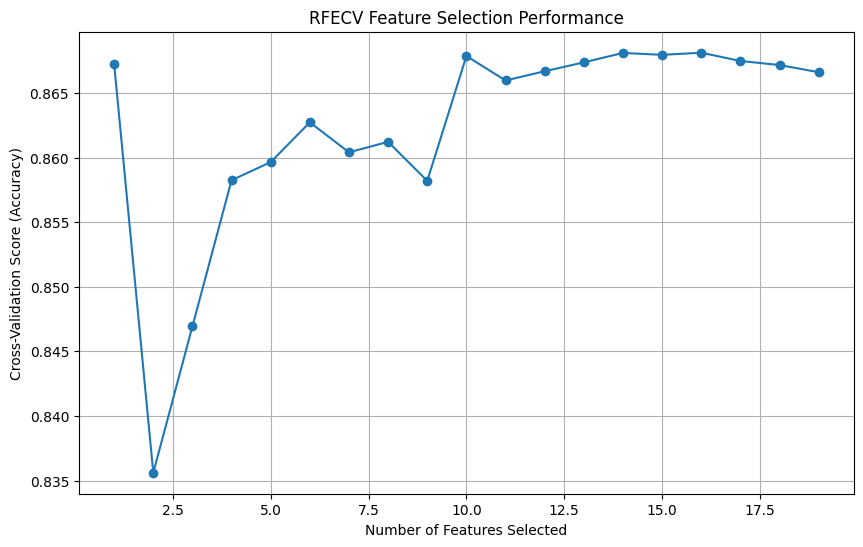

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (Accuracy)")
plt.title("RFECV Feature Selection Performance")
plt.grid(True)
plt.show()

In [ ]:
# Load the saved RFECV model
rfecv_loaded = joblib.load("rfecv_model_v2.pkl")
print("RFECV model loaded successfully!")

selected_features = X_train.columns[rfecv_loaded.support_]
print("Selected Features:", selected_features.tolist())

RFECV model loaded successfully!
Selected Features: ['date', 'total_reviews_for_restaurant', 'avg_rating_for_restaurant', 'std_dev_rating_for_restaurant', 'review_frequency_for_restaurant', 'extreme_rating_index', 'user_restaurants_reviewed', 'rating_mean', 'rating_min', 'rating_std', 'user_earliest', 'user_latest', 'user_days_active', 'user_review_timespan', 'users_avg_per_day', 'user_active_percentage']


### Display Selected Features

In [ ]:
import joblib
import numpy as np

# Load the saved RFECV model
rfecv_loaded = joblib.load("rfecv_model.pkl")


# Convert Variance Threshold and Mutual Info feature selections to sets
features_baseline = set(FE_train.columns[baseline_model_FE.get_support()])
features_mutual_info = set(FE_train.columns[mi_selector_FE.get_support()]) 
features_RFE = set(np.array(FE_train.columns)[rfe_selector_FE.get_support()])
features_RFECV = set(np.array(FE_train.column)[selected_features.tolist()])

features_to_dropMI = features_baseline - features_mutual_info
features_to_dropRFE = features_baseline - features_RFE
features_to_dropRFECV = features_baseline - features_RFECV


print(f"Baseline ({len(features_baseline)}):", list(features_baseline))

print(f"Columns selected by MI({len(features_mutual_info)}):", list(features_mutual_info))
print(f"Columns selected by RFE ({len(features_RFE)}):", list(features_RFE))
print(f"Columns selected by RFECV ({len(features_RFECV)}):", list(features_RFECV))

print(f"Drop MI: {features_to_dropMI}")
print(f"Drop RFE: {features_to_dropRFE}")
print(f"Drop RFECV: {features_to_dropRFECV}")




RFECV model loaded successfully!
RFECV Selected Features (16): ['user_earliest', 'extreme_rating_index', 'users_avg_per_day', 'total_reviews_for_restaurant', 'user_restaurants_reviewed', 'user_review_timespan', 'avg_rating_for_restaurant', 'review_frequency_for_restaurant', 'std_dev_rating_for_restaurant', 'rating_mean', 'rating_std', 'user_latest', 'user_active_percentage', 'user_days_active', 'rating_min', 'date']
Columns selected by VarianceThreshold (19): ['rating', 'avg_rating_for_restaurant', 'rating_std', 'date', 'user_restaurants_reviewed', 'std_dev_rating_for_restaurant', 'user_latest', 'rating_min', 'rating_max', 'median_rating_for_restaurant', 'extreme_rating_index', 'total_reviews_for_restaurant', 'user_review_timespan', 'user_days_active', 'user_earliest', 'users_avg_per_day', 'review_frequency_for_restaurant', 'rating_mean', 'user_active_percentage']
Columns selected by MI(10): ['rating_max', 'median_rating_for_restaurant', 'rating', 'users_avg_per_day', 'user_restaurants

In [50]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Define a function to apply Lasso feature selection
def apply_lasso(X_train, y_train, selected_features):
    """Applies Lasso and returns selected features"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[selected_features])  # Standardize features

    # Apply Lasso with Cross-Validation to determine the best alpha
    lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

    # Keep only features with non-zero coefficients
    lasso_selected_features = [feature for feature, coef in zip(selected_features, lasso.coef_) if coef != 0]

    print(f"Lasso Selected {len(lasso_selected_features)} Features from {len(selected_features)}")
    return lasso_selected_features


In [51]:
# Apply Lasso to MI, RFE, and RFECV selected features
lasso_MI = apply_lasso(FE_train, y_train, list(features_mutual_info))
lasso_RFE = apply_lasso(FE_train, y_train, list(features_RFE))
lasso_RFECV = apply_lasso(FE_train, y_train, list(features_RFECV))


Lasso Selected 9 Features from 10
Lasso Selected 9 Features from 10
Lasso Selected 14 Features from 16


In [ ]:
print(f"Lasso-Refined Features from MI ({len(lasso_MI)}): {lasso_MI}")
print(f"Lasso-Refined Features from RFE ({len(lasso_RFE)}): {lasso_RFE}")
print(f"Lasso-Refined Features from RFECV ({len(lasso_RFECV)}): {lasso_RFECV}")

features_baseline = set(FE_train.columns)  
features_mutual_info = set(FE_train.columns[mi_selector_FE.get_support()]) 
features_RFE = set(np.array(FE_train.columns)[rfe_selector_FE.get_support()])
features_RFECV = set(FE_train.columns[rfecv_loaded.support_])

lasso_MI = set(lasso_MI)
lasso_RFE = set(lasso_RFE)
lasso_RFECV = set(lasso_RFECV)

lasso_features_to_dropMI = features_mutual_info - lasso_MI
lasso_features_to_dropRFE = features_RFE - lasso_RFE
lasso_features_to_dropRFECV = features_RFECV - lasso_RFECV  

print(f"Drop Lasso MI: {lasso_features_to_dropMI}")
print(f"Drop Lasso RFE: {lasso_features_to_dropRFE}")
print(f"Drop Lasso RFECV: {lasso_features_to_dropRFECV}")

Lasso-Refined Features from MI (9): ['rating_max', 'median_rating_for_restaurant', 'rating', 'users_avg_per_day', 'user_review_timespan', 'rating_std', 'rating_mean', 'user_active_percentage', 'user_days_active']
Lasso-Refined Features from RFE (9): ['users_avg_per_day', 'total_reviews_for_restaurant', 'user_review_timespan', 'avg_rating_for_restaurant', 'review_frequency_for_restaurant', 'std_dev_rating_for_restaurant', 'rating_mean', 'user_latest', 'date']
Lasso-Refined Features from RFECV (14): ['extreme_rating_index', 'users_avg_per_day', 'total_reviews_for_restaurant', 'user_review_timespan', 'avg_rating_for_restaurant', 'review_frequency_for_restaurant', 'std_dev_rating_for_restaurant', 'rating_mean', 'rating_std', 'user_latest', 'user_active_percentage', 'user_days_active', 'rating_min', 'date']
Drop Lasso MI: {'user_restaurants_reviewed'}
Drop Lasso RFE: {'user_earliest'}
Drop Lasso RFECV: {'user_earliest', 'user_restaurants_reviewed'}


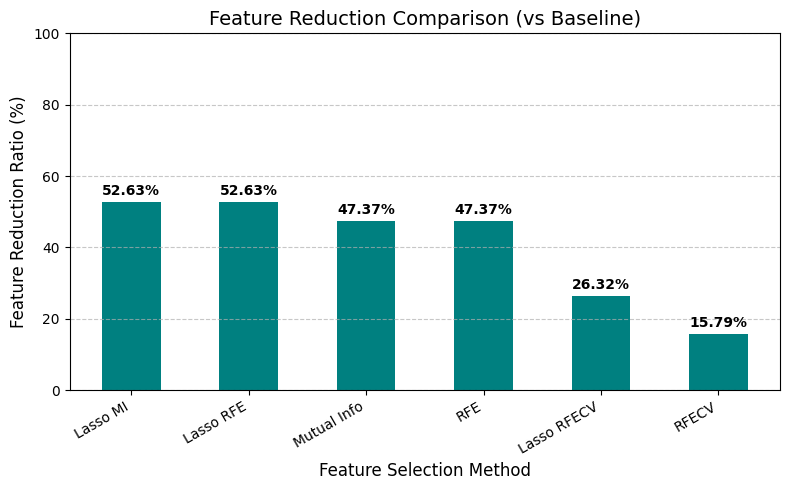

{'Mutual Info': 47.36842105263158,
 'RFE': 47.36842105263158,
 'RFECV': 15.789473684210531,
 'Lasso MI': 52.63157894736843,
 'Lasso RFE': 52.63157894736843,
 'Lasso RFECV': 26.315789473684216}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the total number of features before selection (from baseline)
total_features = 19  


feature_counts = {
    "Mutual Info": 10,
    "RFE": 10,
    "RFECV": 16,
    "Lasso MI": 9,
    "Lasso RFE": 9,
    "Lasso RFECV": 14
}

# Compute Feature Reduction Ratio
feature_reduction_ratios = {
    method: (1 - (feature_counts[method] / total_features)) * 100 for method in feature_counts
}

sorted_methods = sorted(feature_reduction_ratios.keys(), key=lambda x: feature_reduction_ratios[x], reverse=True)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(sorted_methods, [feature_reduction_ratios[m] for m in sorted_methods], color="teal", width=0.5)

# Labels and title
ax.set_xlabel("Feature Selection Method", fontsize=12)
ax.set_ylabel("Feature Reduction Ratio (%)", fontsize=12)
ax.set_title("Feature Reduction Comparison (vs Baseline)", fontsize=14)
ax.set_ylim(0, 100)

# Add values on top of bars
for i, method in enumerate(sorted_methods):
    ax.text(i, feature_reduction_ratios[method] + 2, f"{feature_reduction_ratios[method]:.2f}%", 
            ha='center', fontsize=10, fontweight='bold')

plt.xticks(rotation=30, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Return ratios
feature_reduction_ratios
